# Hidden Drivers Behind the Paycheck Protection Program: The Story of Georgia 


### Dishant Vakte, I-Ju Lin, Naila Sharmin

Abstract:
The SBA introduced PPP to keep the workforce employed by providing businesses with uncollateralized, low-interest loans. But how this money was allocated and what types of businesses were actually benefited from the program remains the question, as many applications were removed from the application datasets without explanation. For our project, we analyzed 2 datasets containing information on approved and rejected loans of businesses from the state of Georgia. Our aim was to figure out whether there are any regional, economical, demographical, and political factors that affect the approval of the loan applications and whether there is any possibility of redlining. Our initial finding indicated that the majority of the removed applications come from congressional districts with a specific political affiliation and primarily were from areas of low income. To dig deep into our findings, we selected variables to identify the characteristics of the removed applications and what differs from the approved ones. Our preliminary analysis indicates that the number of jobs retained, Lender organization, Congressional district, Racial Demography, and Type of Business are influencing factors and may affect the allocation and approval of loans. Models like regression and decision trees will help to classify the influential factors behind an application's acceptance/removal and to predict whether or not a loan will be removed from the application dataset.


In [137]:
#Importing the necessary libraries

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import io
import matplotlib.pyplot as plt

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

### Importing the necessary datasets

In [142]:
Approved_loan = pd.read_csv('ppp_applicants_ga_full.csv')

In [143]:
income = pd.read_excel('Median Household income.xlsx') #Contains the meadian income by congressional district

In [144]:
Removed_loan=pd.read_excel('ppp-removed-ga.xlsx')

In [145]:
zc_db = pd.read_excel('zip_code_database.xlsx') #contains county name by zipcode

In [146]:
population = pd.read_excel('population_percentage.xlsx') #Population distribution by congressional district

In [147]:
cd=pd.read_excel('party.xlsx') #Incumbent political party by congressional district

In [148]:
naics=pd.read_excel('6-digit_2017_Codes.xlsx') #Type of business by NAICS code

# 1.Cleaning and Data preprocessing

Before starting to work on the datasets, we clean the datasets and fix any anomalies in the dataset like missing values. 

In [149]:
Approved_loan.isna().sum() #Displays the number of Na present in each column

name                                   1
amount                                 0
state                                  0
address                                1
city                                   0
zip                                    0
naics_code                          2340
business_type                         41
jobs_retained                          0
date_approved                          0
lender                                 0
congressional_district                 5
loan_number                            0
sba_office_code                        0
processing_method                      0
loan_status                            0
term                                   0
sba_guaranty_percentage                0
initial_approval_amount                0
current_approval_amount                0
undisbursed_amount                   115
servicing_lender_location_id           0
servicing_lender_name                  0
servicing_lender_address               0
servicing_lender

In [150]:
#Replacing the Na with appropriate values
Approved_loan['forgiveness_amount'] =Approved_loan['forgiveness_amount'].replace(np.nan, 0)
Approved_loan['naics_code'] =Approved_loan['naics_code'].replace(np.nan, 0) #As a place holder
Approved_loan['business_type'] =Approved_loan['business_type'].replace(np.nan, 'unknown') 
Approved_loan['project_county_name'] =Approved_loan['project_county_name'].replace(np.nan, 'unknown') 

Where the forgiveness amount is missing, we assume that no amount was forgiven and replace Na with 0.
For the missing naics code, 0 is added. And the Na in business type and project county name are replaced by 'unknown'.

In [151]:
Removed_loan.isna().sum()

name                                  0
amount                                0
state                                 0
address                               0
city                                  0
zip                                   0
naics_code                            0
business_type                         0
jobs_retained                         0
date_approved                         0
lender                                0
congressional_district                0
loan_number                           0
sba_office_code                       0
processing_method                     0
loan_status                           0
term                                  0
sba_guaranty_percentage               0
initial_approval_amount               0
current_approval_amount               0
undisbursed_amount                    1
servicing_lender_location_id          0
servicing_lender_name                 0
servicing_lender_address              0
servicing_lender_city                 0


In [152]:
#Replacing the Na with appropriate values
Removed_loan['forgiveness_amount'] =Removed_loan['forgiveness_amount'].replace(np.nan, 0)
Removed_loan['naics_code'] =Removed_loan['naics_code'].replace(np.nan, 0) #As a place holder
Removed_loan['business_type'] =Removed_loan['business_type'].replace(np.nan, 'others') 
Removed_loan['project_county_name'] =Removed_loan['project_county_name'].replace(np.nan, 'unknown') 

Where the forgiveness amount is missing, we assume that no amount was forgiven and replace Na with 0.
For the missing naics code, 0 is added. And the Na in business type and project county name are replaced by 'unknown'.

In [153]:
Approved_loan.isna().sum()

name                                   1
amount                                 0
state                                  0
address                                1
city                                   0
zip                                    0
naics_code                             0
business_type                          0
jobs_retained                          0
date_approved                          0
lender                                 0
congressional_district                 5
loan_number                            0
sba_office_code                        0
processing_method                      0
loan_status                            0
term                                   0
sba_guaranty_percentage                0
initial_approval_amount                0
current_approval_amount                0
undisbursed_amount                   115
servicing_lender_location_id           0
servicing_lender_name                  0
servicing_lender_address               0
servicing_lender

Adding a column of approval status and later merging Approve_loan and Removed_loan datasets for further analysis.

In [154]:
Approved_loan["approved_or_not"]=1 #For approved loans approved_or_not = 1
Removed_loan["approved_or_not"]=0 #For removed loans approved_or_not = 0

In [155]:
#Merging both the datasets into one
All_loan=pd.concat([Approved_loan,Removed_loan],axis=0)

The city, project city and originating_lender_city columns contain names of the same city in different format. Like Atlanta and ATLANTA. Converting the entire column to upper to bring uniformity.

In [156]:
All_loan['city'].value_counts() #Unique values for the city variable

Atlanta           71581
ATLANTA           17736
Decatur           13845
Lawrenceville     13244
Marietta          12770
                  ...  
1332 Bass Lane        1
martin                1
49 Pryor St.          1
Swanee                1
Dougalsville          1
Name: city, Length: 2785, dtype: int64

In [157]:
All_loan.city = All_loan.city.str.upper() #Changing all the data points to upper case

In [158]:
All_loan['city'].value_counts() #New Unique count for city

ATLANTA            89859
MARIETTA           17636
LAWRENCEVILLE      15962
DECATUR            15881
LITHONIA           11438
                   ...  
MOUNTAINS              1
MOBILE                 1
211 RIDGE AVE S        1
STONEBRIDGE            1
CARTERSVILLE,          1
Name: city, Length: 1643, dtype: int64

In [159]:
All_loan['project_city'].value_counts() #Unique count for city

Atlanta           71664
ATLANTA           17635
Decatur           13861
Lawrenceville     13249
Marietta          12769
                  ...  
ATLANTA, GA           1
49 Pryor St.          1
ETHENS                1
1332 Bass Lane        1
Dougalsville          1
Name: project_city, Length: 2800, dtype: int64

In [160]:
All_loan.project_city = All_loan.project_city.str.upper() #Changing all the data points to upper case

In [161]:
All_loan['project_city'].value_counts() #New Unique count for city

ATLANTA                89844
MARIETTA               17634
LAWRENCEVILLE          15962
DECATUR                15877
LITHONIA               11437
                       ...  
948 RAILROAD STREET        1
VADLOSTA                   1
JOHNS CREEEK               1
GRIFFEN                    1
CARTERSVILLE,              1
Name: project_city, Length: 1657, dtype: int64

In [162]:
All_loan.originating_lender_city.value_counts() #Unique value counts

Phoenix         57324
Bedford         52249
Laguna Hills    40865
CHARLOTTE       35381
Miami           35095
                ...  
MARS                1
MORGANTOWN          1
TOLEDO              1
TIPP CITY           1
SALLISAW            1
Name: originating_lender_city, Length: 863, dtype: int64

In [163]:
All_loan.originating_lender_city = All_loan.originating_lender_city.str.upper() #Changing all the data points to upper case
All_loan.originating_lender_city.value_counts()

PHOENIX         57359
BEDFORD         52266
LAGUNA HILLS    40865
CHARLOTTE       35381
MIAMI           35163
                ...  
CHESTER             1
THORNTOWN           1
JERSEY CITY         1
IRVING              1
GREENBRIER          1
Name: originating_lender_city, Length: 823, dtype: int64

Some Zipcodes are in the XXXXX-XXXX format and some are in XXXXX format. Creating a new column with only the first 5 digits of the zipcode.

In [164]:
#splitting the zipcode column on '-' and creating a new column 'zipcode' with only 5 digits
zipcode = All_loan["zip"].str.split("-", n = 1, expand = True)
All_loan['zipcode'] = zipcode[0]

In [165]:
All_loan['zipcode'].isna().sum()

1633

The Na values are from the zipcodes which were in the XXXXX format and did not get split on '-'. Replacing them with the original value in the new column.

In [166]:
All_loan.zipcode.fillna(All_loan.zip,inplace=True) 

In [167]:
All_loan['zipcode'].isna().sum()

0

In [168]:
naics

,2017 NAICS Code,2017 NAICS Title,Unnamed: 2
0,NaN,NaN,NaN
1,111110.0,Soybean Farming,NaN
2,111120.0,Oilseed (except Soybean) Farming,NaN
3,111130.0,Dry Pea and Bean Farming,NaN
4,111140.0,Wheat Farming,NaN
...,...,...,...
1053,926140.0,Regulation of Agricultural Marketing and Commo...,NaN
1054,926150.0,"Regulation, Licensing, and Inspection of Misce...",NaN
1055,927110.0,Space Research and Technology,NaN
1056,928110.0,National Security,NaN


In [169]:
naics.drop('Unnamed: 2', axis = 1, inplace = True) #Deleting the extra column present in the dataset 

In [170]:
naics.rename(columns={'2017 NAICS Code':'naics_code'},inplace = True) #chainging the name of the column to match to the All_loans dataset

In [171]:
naics

,naics_code,2017 NAICS Title
0,NaN,NaN
1,111110.0,Soybean Farming
2,111120.0,Oilseed (except Soybean) Farming
3,111130.0,Dry Pea and Bean Farming
4,111140.0,Wheat Farming
...,...,...
1053,926140.0,Regulation of Agricultural Marketing and Commo...
1054,926150.0,"Regulation, Licensing, and Inspection of Misce..."
1055,927110.0,Space Research and Technology
1056,928110.0,National Security


Adding NAICS title column to the dataset

In [172]:
loans = pd.merge(All_loan, naics, on='naics_code', how='left') #new dataset loans with naics title

In [173]:
loans.rename(columns={'2017 NAICS Title':'naics_title'},inplace = True) #Renaming the title column

In [174]:
loans

,name,amount,state,address,city,zip,naics_code,business_type,jobs_retained,date_approved,...,originating_lender_city,originating_lender_state,loan_status_date,originating_lender_location_id,lmi_indicator,forgiveness_amount,forgiveness_date,approved_or_not,zipcode,naics_title
0,LUMMUS CORPORATION,2000000.0,GA,225 Bourne Blvd,SAVANNAH,31408-9586,333249.0,Corporation,294,2021-02-20,...,CHICAGO,IL,NaN,116998,N,0.00,NaN,1,31408,Other Industrial Machinery Manufacturing
1,COLIANT SOLUTIONS INC.,1294555.0,GA,2703 Brickton North Dr,BUFORD,30518-9101,541519.0,Corporation,63,2021-01-31,...,COLUMBUS,GA,NaN,19248,Y,0.00,NaN,1,30518,Other Computer Related Services
2,YOHE PLUMBING INC,729509.0,GA,1120 Franke Court N/A,AUGUSTA,30909,238220.0,Corporation,105,2021-03-12,...,PHOENIXVILLE,PA,NaN,121536,N,0.00,NaN,1,30909,"Plumbing, Heating, and Air-Conditioning Contra..."
3,LEWIS COLOR LITHOGRAPHERS INC,571193.4,GA,30 Joe Kennedy Blvd,STATESBORO,30458-3417,323111.0,Corporation,49,2021-02-02,...,COLUMBUS,GA,NaN,19248,N,0.00,NaN,1,30458,Commercial Printing (except Screen and Books)
4,"ALMA PAK INTERNATIONAL, LLC",472700.0,GA,230 PINEVIEW RD,ALMA,31510-4326,445230.0,Partnership,37,2020-04-10,...,ALMA,GA,2021-01-08,17811,N,475877.59,2020-12-15,1,31510,Fruit and Vegetable Markets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579659,DONNELL WILSON,1950.0,GA,1000 Paces Ln,WOODSTOCK,30189-4829,621511.0,Sole Proprietorship,1,2021-04-01 00:00:00,...,LAGUNA HILLS,CA,2021-04-01 00:00:00,509316,N,0.00,NaN,0,30189,Medical Laboratories
579660,MAMADOU DIOULDE DIALLO,1849.0,GA,7000 Roswell Rd Apt 252,ATLANTA,30328-2389,485310.0,Independent Contractors,1,2021-05-21 00:00:00,...,BEDFORD,TX,2021-05-21 00:00:00,529472,N,0.00,NaN,0,30328,Taxi Service
579661,ANTHONY HARRIS,1245.0,GA,2849 Blount St,ATLANTA,30344-3732,485310.0,Independent Contractors,1,2021-04-08 00:00:00,...,BEDFORD,TX,2021-04-08 00:00:00,529472,Y,0.00,NaN,0,30344,Taxi Service
579662,TAAHIRA ROBINSON,1075.0,GA,8541 Glendevon Ct,RIVERDALE,30274-4573,561110.0,Limited Liability Company(LLC),1,2021-05-11 00:00:00,...,MIAMI,FL,2021-05-11 00:00:00,529192,Y,0.00,NaN,0,30274,Office Administrative Services


In [175]:
loans.isnull().sum() #Checking for Na values.

name                                   1
amount                                 0
state                                  0
address                                1
city                                   1
zip                                    0
naics_code                             0
business_type                          0
jobs_retained                          0
date_approved                          0
lender                                 0
congressional_district                 5
loan_number                            0
sba_office_code                        0
processing_method                      0
loan_status                            0
term                                   0
sba_guaranty_percentage                0
initial_approval_amount                0
current_approval_amount                0
undisbursed_amount                   116
servicing_lender_location_id           0
servicing_lender_name                  0
servicing_lender_address               0
servicing_lender

In [176]:
loans['naics_title'] =loans['naics_title'].replace(np.nan, 'others') #Replacing the missing NAICS titles with 'others'

Adding the median income by congressional district to the loans dataset

In [177]:
income

,congressional_district,Median Household Income
0,GA-01,55542
1,GA-02,39728
2,GA-03,66614
3,GA-04,60128
4,GA-05,60247
5,GA-06,100110
6,GA-07,80926
7,GA-08,50745
8,GA-09,59728
9,GA-10,61151


In [178]:
#Adding the median income by congressional district to the dataset
loans = pd.merge(loans, income, on= 'congressional_district', how= 'left')

In [179]:
loans

,name,amount,state,address,city,zip,naics_code,business_type,jobs_retained,date_approved,...,originating_lender_state,loan_status_date,originating_lender_location_id,lmi_indicator,forgiveness_amount,forgiveness_date,approved_or_not,zipcode,naics_title,Median Household Income
0,LUMMUS CORPORATION,2000000.0,GA,225 Bourne Blvd,SAVANNAH,31408-9586,333249.0,Corporation,294,2021-02-20,...,IL,NaN,116998,N,0.00,NaN,1,31408,Other Industrial Machinery Manufacturing,55542.0
1,COLIANT SOLUTIONS INC.,1294555.0,GA,2703 Brickton North Dr,BUFORD,30518-9101,541519.0,Corporation,63,2021-01-31,...,GA,NaN,19248,Y,0.00,NaN,1,30518,Other Computer Related Services,80926.0
2,YOHE PLUMBING INC,729509.0,GA,1120 Franke Court N/A,AUGUSTA,30909,238220.0,Corporation,105,2021-03-12,...,PA,NaN,121536,N,0.00,NaN,1,30909,"Plumbing, Heating, and Air-Conditioning Contra...",50217.0
3,LEWIS COLOR LITHOGRAPHERS INC,571193.4,GA,30 Joe Kennedy Blvd,STATESBORO,30458-3417,323111.0,Corporation,49,2021-02-02,...,GA,NaN,19248,N,0.00,NaN,1,30458,Commercial Printing (except Screen and Books),50217.0
4,"ALMA PAK INTERNATIONAL, LLC",472700.0,GA,230 PINEVIEW RD,ALMA,31510-4326,445230.0,Partnership,37,2020-04-10,...,GA,2021-01-08,17811,N,475877.59,2020-12-15,1,31510,Fruit and Vegetable Markets,55542.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579659,DONNELL WILSON,1950.0,GA,1000 Paces Ln,WOODSTOCK,30189-4829,621511.0,Sole Proprietorship,1,2021-04-01 00:00:00,...,CA,2021-04-01 00:00:00,509316,N,0.00,NaN,0,30189,Medical Laboratories,76640.0
579660,MAMADOU DIOULDE DIALLO,1849.0,GA,7000 Roswell Rd Apt 252,ATLANTA,30328-2389,485310.0,Independent Contractors,1,2021-05-21 00:00:00,...,TX,2021-05-21 00:00:00,529472,N,0.00,NaN,0,30328,Taxi Service,100110.0
579661,ANTHONY HARRIS,1245.0,GA,2849 Blount St,ATLANTA,30344-3732,485310.0,Independent Contractors,1,2021-04-08 00:00:00,...,TX,2021-04-08 00:00:00,529472,Y,0.00,NaN,0,30344,Taxi Service,60247.0
579662,TAAHIRA ROBINSON,1075.0,GA,8541 Glendevon Ct,RIVERDALE,30274-4573,561110.0,Limited Liability Company(LLC),1,2021-05-11 00:00:00,...,FL,2021-05-11 00:00:00,529192,Y,0.00,NaN,0,30274,Office Administrative Services,66203.0


# 2. **EDA and Visualizations**

#### 1. Plotting a heatmap of correlation

The heatmap shows the correlation between variables and which variables might be dependent on each other.

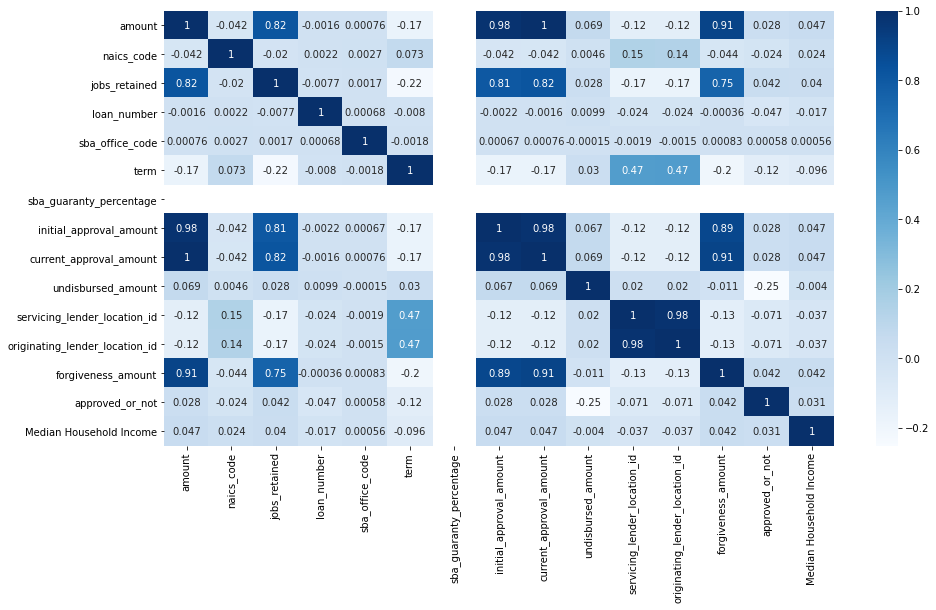

In [201]:
#Plotting the heatmap
plt.figure(figsize=(15,8))
sns.heatmap(loans.corr(),cbar=True,annot=True,cmap='Blues')
plt.show()

As the Paycheck Protection program was mainly initated to save jobs by funding small businesses, the histogram shows that as the number of jobs retained goes up, the forgiveness amount also goes up. 
There also seems to be a strong correlation between the amount of loan and the number of jobs retained.

#### 2.  Plotting what effect business age has on removal and approval

Plotting a count plot to see the number of businesses approved and removed per business age category.

In [204]:
loans.business_age_description[loans.approved_or_not == 1].value_counts()

Existing or more than 2 years old         511266
New Business or 2 years or less            26578
Unanswered                                 15863
Startup, Loan Funds will Open Business        75
Change of Ownership                           46
Name: business_age_description, dtype: int64

In [205]:
loans.business_age_description[loans.approved_or_not == 0].value_counts()

Existing or more than 2 years old    25799
New Business or 2 years or less         31
Unanswered                               6
Name: business_age_description, dtype: int64

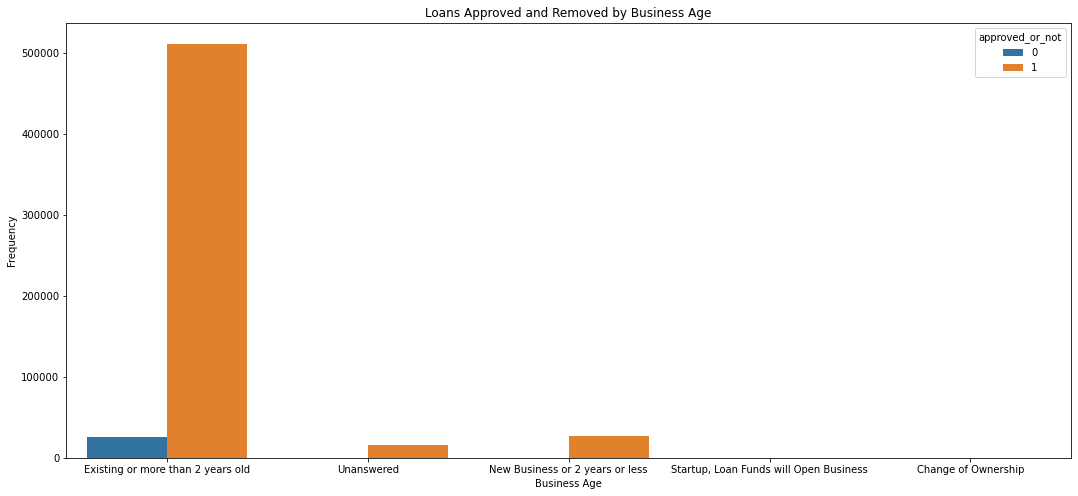

In [212]:
plt.figure(figsize=(18,8))
sns.countplot(x=loans.business_age_description, hue = loans.approved_or_not)
plt.xlabel("Business Age")
plt.ylabel("Frequency")
plt.title("Loans Approved and Removed by Business Age")
plt.show()

There are no loans removed from startups and change of ownership firms. As the number of these appliactions are also very small as compared to the other types, it is difficult to draw conclusions.

#### 3. Plotting the loan status and the loan amount

Plotting the amounts on loan_status would help identify if any patterns exist.

<Figure size 1296x576 with 0 Axes>

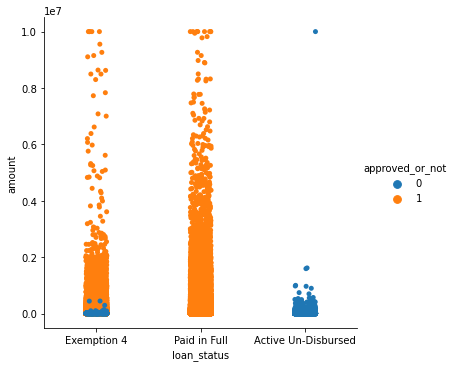

In [213]:
plt.figure(figsize=(18,8))
sns.catplot(data = loans, x="loan_status", y ="amount", hue ="approved_or_not")
plt.show()

The plot shows that most of the removed loans which were of type Exemption 4 were very small amounts as compared to the rest. Most of the removed loans are comparatively of lesser amounts as compared to the approved ones, with only one outlier.

#### 4. Plotting the number of forgiven loans by dates

Splitting the dates into YYYY-MM format for plotting the histogram

In [180]:
#Splitting on '-' to extract year and month
fyear = loans["forgiveness_date"].str.split("-", n = 1, expand = True)
loans['forgiveness_year'] = fyear[0]
fmonth = fyear[1].str.split("-", n = 1, expand = True)
loans['forgiveness_month'] = fmonth[0]

In [181]:
print(loans.forgiveness_month.isna().sum())
print(loans.forgiveness_year.isna().sum())

208467
208467


The Nas represent the loans which have not been forgiven. Placing the Na by --.

In [182]:
loans['forgiveness_year'].replace(np.nan, '--', inplace = True)
loans['forgiveness_month'].replace(np.nan, '--', inplace = True)

In [183]:
#Extract the date in YYYY-MM format by splitting from the right on '-' using rsplit 
fdate = loans["forgiveness_date"].str.rsplit("-", n = 1, expand = True)
loans['forgiveness_year_month'] = fdate[0]

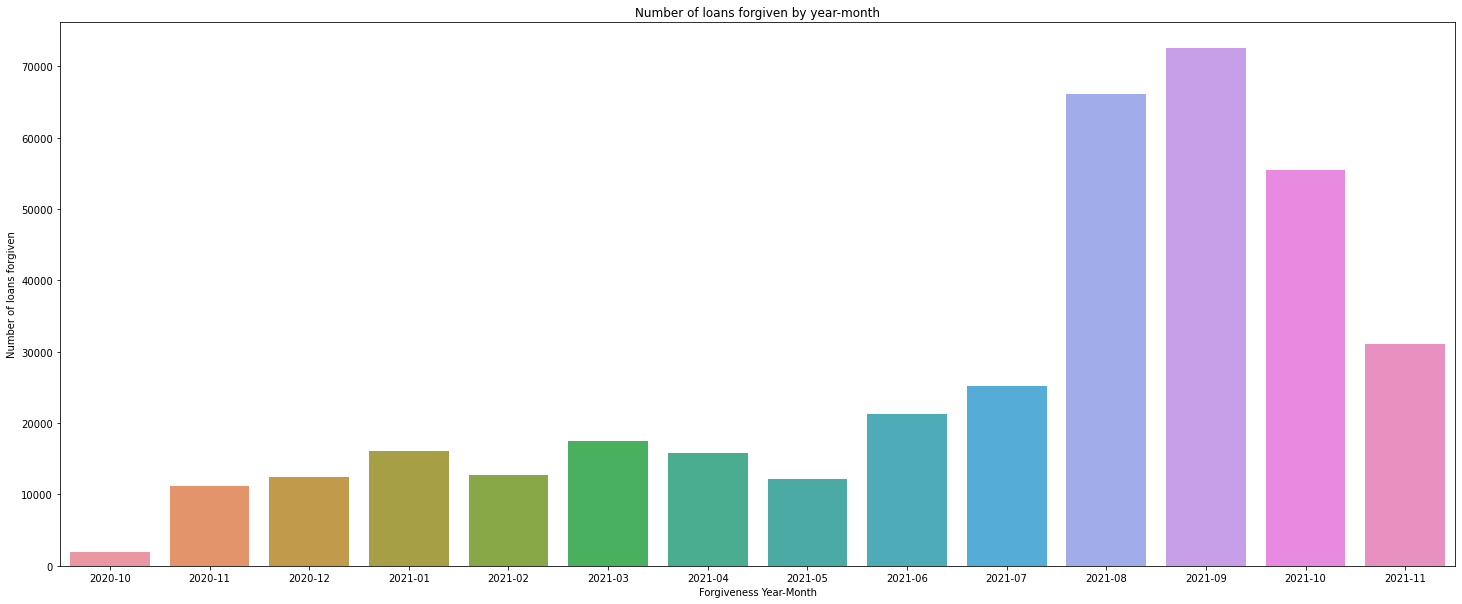

In [192]:
#Plotting the histogram
loans.sort_values(by="forgiveness_year_month")
plt.figure(figsize=(25,10))
sns.countplot(x=loans.sort_values(by="forgiveness_year_month").forgiveness_year_month)
plt.xlabel("Forgiveness Year-Month")
plt.ylabel("Number of loans forgiven")
plt.title("Number of loans forgiven by year-month")
plt.show()

From the histogram it can be seen that the majority of the loans forgiven are in August, September, October and November of 2021. The reasons for this could be that the PPP recieved funding during that time period.

#### 5. Checking the percentage of loans removed per congressional district.

Dataframes of counts of loans approved and rejected from specific congressional districts are created and then the two datasets are merged together to calculate the percentage of removed loans and plot a barchart.

In [185]:
#Dataframes of the counts of approved and rejected loans per congressional district
AL_CD = pd.DataFrame(Approved_loan.congressional_district.value_counts().reset_index().values, columns=["congressional_district", "count"])
RL_CD = pd.DataFrame(Removed_loan.congressional_district.value_counts().reset_index().values, columns=["congressional_district", "count"])

In [186]:
#Merging the datasets together
CD_merged = pd.merge(AL_CD, RL_CD, on='congressional_district', how='left') 

In [187]:
#Renaming the column
CD_merged.rename(columns={'count_x':'approved_count','count_y':'removed_count'},inplace = True)

In [188]:
#Removing the rows which have Na in the removed count
CD_merged.dropna(subset = ["removed_count"], inplace=True)

In [189]:
#Calculating the percentage of removed loans per congressional district and storing it in a new column.
CD_merged['removal_percent'] =  CD_merged['removed_count']*100/ (CD_merged['approved_count'] + CD_merged['removed_count'])

In [200]:
CDD = CD_merged.sort_values(by = "removal_percent", ascending = False).head(15)
CDD

,congressional_district,approved_count,removed_count,removal_percent
1,GA-13,64945,4044,5.861804
2,GA-04,63122,3656,5.474857
7,GA-02,36658,2079,5.366962
0,GA-05,75046,3995,5.054339
5,GA-03,38385,2006,4.966453
9,GA-10,28923,1372,4.5288
8,GA-08,30761,1416,4.400659
10,GA-12,26053,1140,4.192255
11,GA-01,24420,1028,4.03961
13,GA-14,16546,614,3.578089


Loans from GA-13, GA-04, GA-02, GA-05, and GA-03 have the highest percentage of removed loans. Further investigation is necessary into politics and demographics of these areas to come to definite conclusions.

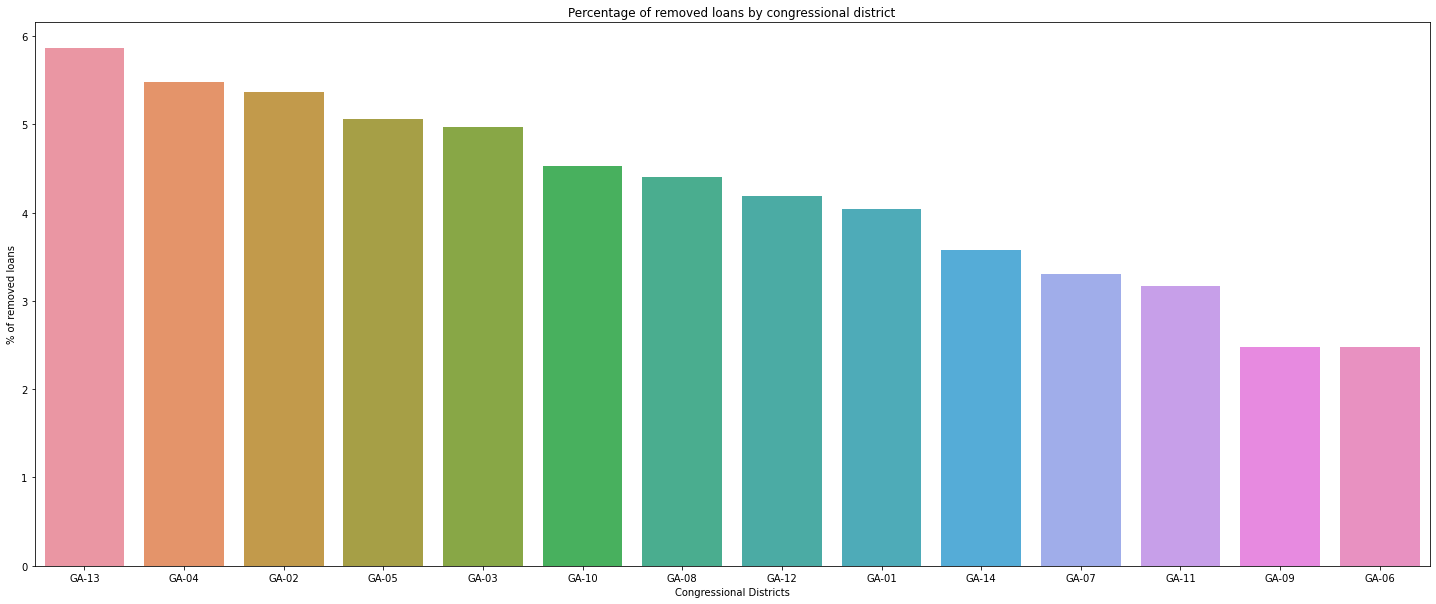

In [199]:
#Plotting a barchart for percentage removed loans vs congressional district
plt.figure(figsize=(25,10))
sns.barplot(x = CDD.congressional_district, y = CDD.removal_percent)
plt.xlabel("Congressional Districts")
plt.ylabel("% of removed loans")
plt.title("Percentage of removed loans by congressional district")
plt.show()

#### 6. Analyzing Lender originating states

Creating a table and a plot using the lender originating state would help identify lenders from which states get their loans removed the most and if there are any patterns behind it.

In [216]:
#Creating dataframes of count of orginiating lender states for approved and removed loans
app_lend_state = pd.DataFrame(loans.originating_lender_state[loans.approved_or_not == 1].value_counts().reset_index().values, columns=["State", "count"]) #Count of approved loans by lender state
rem_lend_state = pd.DataFrame(loans.originating_lender_state[loans.approved_or_not == 0].value_counts().reset_index().values, columns=["State", "count"]) #Count of removed loans by lender state

In [217]:
#Merging both the columns together
lend_state = pd.merge(app_lend_state, rem_lend_state, on='State', how='left') 

In [219]:
#Renaming the columns
lend_state.rename(columns={'count_x':'approved_count','count_y':'removed_count'},inplace = True)
lend_state.dropna(subset = ["removed_count"], inplace=True)

In [234]:
lend_state.head(15)

,State,approved_count,removed_count,removal_percent
17,MA,2588,1942,42.869757
8,PA,17146,2797,14.024971
4,TX,48224,6713,12.219451
3,AZ,52081,5283,9.209609
42,DC,22,2,8.333333
1,CA,69660,5750,7.624983
7,NY,20324,688,3.274319
15,VA,3409,98,2.794411
25,NM,530,13,2.394107
2,FL,69375,1575,2.219873


In [221]:
#Calculating the percentage of removed loans
lend_state['removal_percent'] =  lend_state['removed_count']*100/ (lend_state['approved_count'] + lend_state['removed_count'])

In [232]:
lend_state = lend_state.sort_values(by = 'removal_percent', ascending = False).head(10)
lend_state

,State,approved_count,removed_count,removal_percent
17,MA,2588,1942,42.869757
8,PA,17146,2797,14.024971
4,TX,48224,6713,12.219451
3,AZ,52081,5283,9.209609
42,DC,22,2,8.333333
1,CA,69660,5750,7.624983
7,NY,20324,688,3.274319
15,VA,3409,98,2.794411
25,NM,530,13,2.394107
2,FL,69375,1575,2.219873


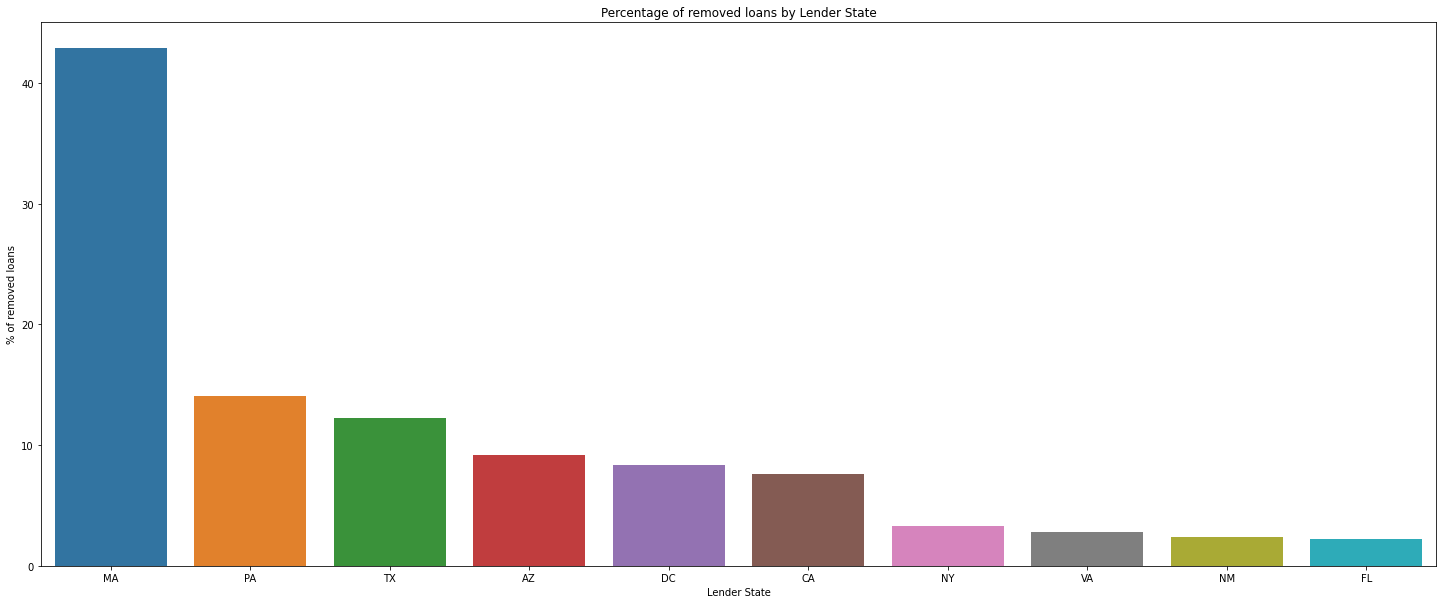

In [233]:
#Plotting a barchart for percentage removed loans vs congressional district
plt.figure(figsize=(25,10))
sns.barplot(x = lend_state.State, y = lend_state.removal_percent)
plt.xlabel("Lender State")
plt.ylabel("% of removed loans")
plt.title("Percentage of removed loans by Lender State")
plt.show()

From the graph it is clear that lenders who are not from GA have a very high removal rate. MA having the maximum at 42.8%, followed by PA and TX. Loans applied to lenders in the same state have a higher chance of getting approved.

#### 7. Exploring patterns between Political parties and removed loans

Creating a table to analyze if there is any relation between political parties and the removed loans, or are loans being removed from congressional district of a particular political party.

In [224]:
#Adding Political Party to loans
loans = pd.merge(loans, cd, on="congressional_district", how='left') 

In [235]:
loans.Party.isna().sum()

0

In [236]:
loans['Party'] =loans['Party'].replace(np.nan, 'unknown')

In [237]:
population_cd = pd.merge(CD_merged, cd , on = "congressional_district", how = "left")

In [239]:
population_cd.sort_values(by = 'removal_percent', ascending = False).head(15)

,congressional_district,approved_count,removed_count,removal_percent,Party
1,GA-13,64945,4044,5.861804,Democratic
2,GA-04,63122,3656,5.474857,Democratic
7,GA-02,36658,2079,5.366962,Democratic
0,GA-05,75046,3995,5.054339,Democratic
5,GA-03,38385,2006,4.966453,Republican
9,GA-10,28923,1372,4.5288,Republican
8,GA-08,30761,1416,4.400659,Republican
10,GA-12,26053,1140,4.192255,Republican
11,GA-01,24420,1028,4.03961,Republican
13,GA-14,16546,614,3.578089,Republican


Although the top 4 congressional districts in terms of loan removal percent are Democratic, there seems to be no evident relation or pattern in the data.

#### 8. Analyzing removal rates by business types 

Analyzing the data to find out what types of businesses have high chances of getting their loans removed.

In [244]:
#Creating a dataframe of counts of business types for approved and removed loans
rbt = pd.DataFrame(loans.business_type[loans.approved_or_not == 0].value_counts().reset_index().values, columns=["business_type", "removed_count"])
abt = pd.DataFrame(loans.business_type[loans.approved_or_not == 1].value_counts().reset_index().values, columns=["business_type", "approved_count"])
#Merging the two dataframes 
bt = pd.merge(abt,rbt, on = 'business_type', how = "left")



In [245]:
#Calculating the removal percentage 
bt['removal_percent'] =  bt['removed_count']*100/ (bt['approved_count'] + bt['removed_count'])
bt.sort_values(by = "removal_percent", ascending = False).head(15)

,business_type,approved_count,removed_count,removal_percent
7,Single Member LLC,5320,605,10.21097
0,Sole Proprietorship,220996,17093,7.179248
4,Independent Contractors,58662,3976,6.347585
15,Joint Venture,87,5,5.434783
19,Employee Stock Ownership Plan(ESOP),23,1,4.166667
11,501(c)3 – Non Profit,334,12,3.468208
3,Self-Employed Individuals,58875,2060,3.380652
9,Limited Liability Partnership,1578,35,2.16987
16,Qualified Joint-Venture (spouses),49,1,2.0
1,Limited Liability Company(LLC),100002,1470,1.448675


In [248]:
bt = bt.sort_values(by = "removal_percent", ascending = False).head(8)

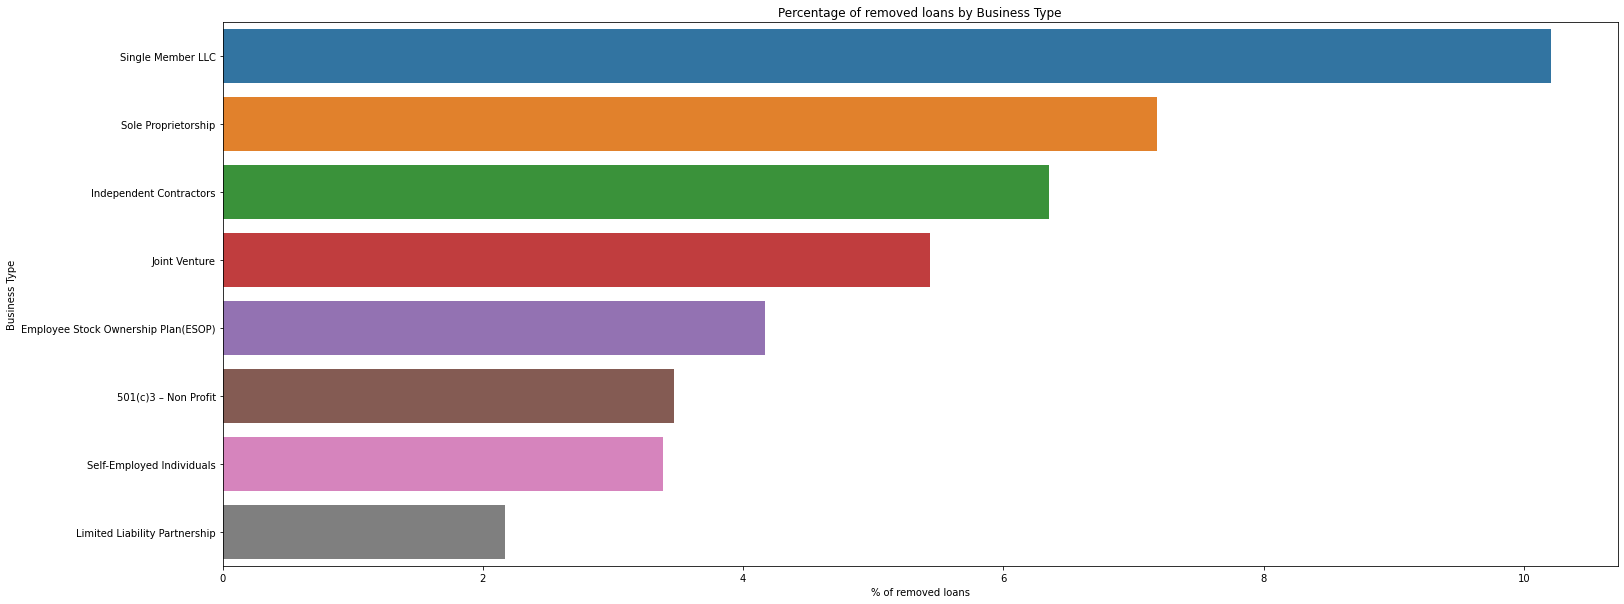

In [250]:
#Plotting a barchart for percentage removed loans vs congressional district
plt.figure(figsize=(25,10))
sns.barplot(y = bt.business_type, x = bt.removal_percent)
plt.xlabel("% of removed loans")
plt.ylabel("Business Type")
plt.title("Percentage of removed loans by Business Type")
plt.show()

From the above graph we can see that the top 3 business types who have highest removal percent are Single Member LLC, Sole Proprietorship and Independent contractors. All the 3 business types could be a single person business which saved only 1 job, that might be the reason these loans were removed.

#### 9. Effect of population on Removed Loans?

We will find out if there is a relation between the majority race of the area and the rate of removal of loans by creating a table and calculting percentages.

In [241]:
#Adding population to the loans 
loans = pd.merge(loans, population[['Asian', 'Black_or_ African_American','White', 'Others', 'congressional_district' ]], on = 'congressional_district', how = 'left')

In [251]:
population_cd

,congressional_district,approved_count,removed_count,removal_percent,Party
0,GA-05,75046,3995,5.054339,Democratic
1,GA-13,64945,4044,5.861804,Democratic
2,GA-04,63122,3656,5.474857,Democratic
3,GA-07,48446,1658,3.309117,Democratic
4,GA-06,43078,1092,2.472266,Democratic
5,GA-03,38385,2006,4.966453,Republican
6,GA-11,38271,1250,3.162875,Republican
7,GA-02,36658,2079,5.366962,Democratic
8,GA-08,30761,1416,4.400659,Republican
9,GA-10,28923,1372,4.5288,Republican


In [253]:
population

,Total_Population,Asian,Black_or_ African_American,White,Others,congressional_district,Asian_percent,Black_perc,White_perc
0,732133,7591,63917,619580,41045,GA-14,1.036833,8.730244,84.626700
1,802943,21507,494566,232947,53923,GA-13,2.678521,61.594160,29.011648
2,732810,12094,251647,426101,42968,GA-12,1.650360,34.340006,58.146177
3,782704,24118,139051,557147,62388,GA-11,3.081369,17.765464,71.182337
4,757807,18729,197751,511091,30236,GA-10,2.471474,26.095167,67.443426
5,771168,10886,50058,674346,35878,GA-09,1.411625,6.491193,87.444759
6,706237,11859,221519,433426,39433,GA-08,1.679181,31.366099,61.371183
7,844773,133582,181314,433565,96312,GA-07,15.812769,21.463044,51.323255
8,742932,87020,102402,495449,58061,GA-06,11.713050,13.783496,66.688338
9,788996,41058,436884,274634,36420,GA-05,5.203829,55.372144,34.808035


In [254]:
#Adding population percentages 
population = pd.merge(population_cd, population[['Asian_percent', 'Black_perc','White_perc', 'Others', 'congressional_district' ]], on = 'congressional_district', how = 'left')

In [256]:
population.sort_values(by='removal_percent', ascending = False)

,congressional_district,approved_count,removed_count,removal_percent,Party,Asian_percent,Black_perc,White_perc,Others
1,GA-13,64945,4044,5.861804,Democratic,2.678521,61.594160,29.011648,53923
2,GA-04,63122,3656,5.474857,Democratic,4.635731,60.872834,27.251957,56623
7,GA-02,36658,2079,5.366962,Democratic,1.012010,52.835311,41.590966,30647
0,GA-05,75046,3995,5.054339,Democratic,5.203829,55.372144,34.808035,36420
5,GA-03,38385,2006,4.966453,Republican,2.058860,25.385154,68.576081,29889
9,GA-10,28923,1372,4.5288,Republican,2.471474,26.095167,67.443426,30236
8,GA-08,30761,1416,4.400659,Republican,1.679181,31.366099,61.371183,39433
10,GA-12,26053,1140,4.192255,Republican,1.650360,34.340006,58.146177,42968
11,GA-01,24420,1028,4.03961,Republican,1.660513,30.687553,62.115957,41517
13,GA-14,16546,614,3.578089,Republican,1.036833,8.730244,84.626700,41045


Even though the first 4 states with the highest removal percentage are with Black or African American majority, the states following also have very similar removal percentages and have a White majority. The tables does not give enough evidence to suggest anything.

#### 10. Investigating for potential fraud applicants.

In [258]:
rem_name = pd.DataFrame(Removed_loan.name.value_counts().reset_index().values, columns=["name", "count"])
rem_name[rem_name['count'] > 3]

,name,count
0,ANTHONY WILLIAMS,7
1,BRITTANY SMITH,6
2,ROBERT SMITH,6
3,MICHAEL SMITH,5
4,MICHAEL BROWN,5
5,TIFFANY JONES,5
6,MICHAEL HARRIS,5
7,JAMES WILLIAMS,5
8,ANTHONY SMITH,5
9,JASMINE JONES,5


In [259]:
loans[loans.name == 'ANTHONY WILLIAMS']

,name,amount,state,address,city,zip,naics_code,business_type,jobs_retained,date_approved,...,naics_title,Median Household Income,forgiveness_year,forgiveness_month,forgiveness_year_month,Party,Asian,Black_or_ African_American,White,Others
2001,ANTHONY WILLIAMS,19415.00,GA,2909 Campbellton Rd SW Apt 4H,ATLANTA,30311-4518,541613.0,Sole Proprietorship,1,2021-03-25,...,Marketing Consulting Services,60247.0,2021,08,2021-08,Democratic,41058.0,436884.0,274634.0,36420.0
15409,ANTHONY WILLIAMS,20486.00,GA,1343 Terrell Mill Rd SE,MARIETTA,30067-5489,811198.0,Sole Proprietorship,1,2021-03-31,...,All Other Automotive Repair and Maintenance,100110.0,--,--,NaN,Democratic,87020.0,102402.0,495449.0,58061.0
16376,ANTHONY WILLIAMS,20833.00,GA,953 Washington St SW Apt 2,ATLANTA,30315-1607,423220.0,Sole Proprietorship,1,2021-04-21,...,Home Furnishing Merchant Wholesalers,60247.0,--,--,NaN,Democratic,41058.0,436884.0,274634.0,36420.0
20807,ANTHONY WILLIAMS,20335.63,GA,86 Hines Rd,WRIGHTSVILLE,31096-4152,484121.0,Independent Contractors,1,2021-04-01,...,"General Freight Trucking, Long-Distance, Truck...",61151.0,--,--,NaN,Republican,18729.0,197751.0,511091.0,30236.0
26900,ANTHONY WILLIAMS,20393.75,GA,133 dewey st,MACON,31206,561720.0,Self-Employed Individuals,1,2021-04-03,...,Janitorial Services,39728.0,--,--,NaN,Democratic,6799.0,354964.0,279421.0,30647.0
43540,ANTHONY WILLIAMS,20833.00,GA,809 Meriwether St,GRIFFIN,30224-4142,484230.0,Independent Contractors,1,2021-03-26,...,Specialized Freight (except Used Goods) Trucki...,66614.0,2021,08,2021-08,Republican,15462.0,190642.0,515005.0,29889.0
46251,ANTHONY WILLIAMS,1708.00,GA,424 Heath Dr,THOMASTON,30286-2784,561730.0,Sole Proprietorship,1,2021-04-28,...,Landscaping Services,66614.0,--,--,NaN,Republican,15462.0,190642.0,515005.0,29889.0
51938,ANTHONY WILLIAMS,20701.00,GA,2419 Old Thompson Bridge Rd,GAINESVILLE,30501-1104,485310.0,Sole Proprietorship,1,2021-05-11,...,Taxi Service,59728.0,--,--,NaN,Republican,10886.0,50058.0,674346.0,35878.0
101623,ANTHONY WILLIAMS,9545.00,GA,3883 Heritage Oaks Dr SW,POWDER SPRINGS,30127-9204,541512.0,Sole Proprietorship,1,2021-04-28,...,Computer Systems Design Services,66203.0,2021,08,2021-08,Democratic,21507.0,494566.0,232947.0,53923.0
114837,ANTHONY WILLIAMS,20832.00,GA,2328 Campbellton Rd SW,ATLANTA,30311-4626,812111.0,Sole Proprietorship,1,2021-05-20,...,Barber Shops,60247.0,--,--,NaN,Democratic,41058.0,436884.0,274634.0,36420.0


In [260]:
loans[loans.name == 'ANTHONY WILLIAMS'].approved_or_not.sum() #Number of approved loans for Anthony

36

1 person, Anthony Williams, applies for a loan 43 times from different addresses and gets approved 36 times. All of the times the business types he has submitted are sole proprietorship, independent contractor or self employeed individual. All of the times the only job he has saved is his own with almost similar amounts of around $20000.
This could be a potential fraud.

In [262]:
loans.name.value_counts()

MICHAEL WILLIAMS             54
MICHAEL JOHNSON              48
JAMES WILLIAMS               48
MICHAEL SMITH                45
ANTHONY WILLIAMS             43
                             ..
AABLE COMMUNICATIONS INC.     1
TOPHAT SECURITY INC.          1
RUSSELL JAMES FARMS, LLC      1
BEARRY COLEMAN                1
GYLNIS SMOOT                  1
Name: name, Length: 462139, dtype: int64

In [263]:
loans[loans.name == 'MICHAEL WILLIAMS'].approved_or_not.sum() #Number of approved loans for Anthony

51

In [264]:
loans[loans.name == 'MICHAEL WILLIAMS']

,name,amount,state,address,city,zip,naics_code,business_type,jobs_retained,date_approved,...,naics_title,Median Household Income,forgiveness_year,forgiveness_month,forgiveness_year_month,Party,Asian,Black_or_ African_American,White,Others
1857,MICHAEL WILLIAMS,20832.00,GA,113 Hedgerow Dr,LEESBURG,31763-5554,811111.0,Sole Proprietorship,1,2021-04-22,...,General Automotive Repair,39728.0,--,--,NaN,Democratic,6799.0,354964.0,279421.0,30647.0
56624,MICHAEL WILLIAMS,4375.00,GA,4112 Pinnacle Way,HEPHZIBAH,30815-6152,484110.0,Independent Contractors,1,2021-04-19,...,"General Freight Trucking, Local",50217.0,--,--,NaN,Republican,12094.0,251647.0,426101.0,42968.0
74071,MICHAEL WILLIAMS,20832.00,GA,620 W Anderson Ln,SAVANNAH,31415-5480,492210.0,Sole Proprietorship,1,2021-05-12,...,Local Messengers and Local Delivery,55542.0,--,--,NaN,Republican,12453.0,230141.0,465838.0,41517.0
77730,MICHAEL WILLIAMS,6873.00,GA,4312 Green Pastures Way,ELLENWOOD,30294-1874,621610.0,Independent Contractors,1,2021-03-13,...,Home Health Care Services,60247.0,2021,10,2021-10,Democratic,41058.0,436884.0,274634.0,36420.0
83580,MICHAEL WILLIAMS,20020.00,GA,5872 Rex Ridge Loop,REX,30273-5240,812112.0,Sole Proprietorship,1,2021-04-17,...,Beauty Salons,60247.0,2021,09,2021-09,Democratic,41058.0,436884.0,274634.0,36420.0
90920,MICHAEL WILLIAMS,19729.00,GA,1656 Grist Mill Dr,MARIETTA,30062-3860,722320.0,Sole Proprietorship,1,2021-04-28,...,Caterers,100110.0,--,--,NaN,Democratic,87020.0,102402.0,495449.0,58061.0
104306,MICHAEL WILLIAMS,20833.00,GA,530 Saint Marlowe Dr,LAWRENCEVILLE,30044-7366,541611.0,Self-Employed Individuals,1,2021-05-22,...,Administrative Management and General Manageme...,80926.0,2021,10,2021-10,Democratic,133582.0,181314.0,433565.0,96312.0
110034,MICHAEL WILLIAMS,8625.00,GA,7673 Overlook Bnd,FAIRBURN,30213-7911,492110.0,Sole Proprietorship,1,2021-03-25,...,Couriers and Express Delivery Services,66203.0,--,--,NaN,Democratic,21507.0,494566.0,232947.0,53923.0
115726,MICHAEL WILLIAMS,20833.00,GA,2991 Aviator Cir,SNELLVILLE,30039-5423,811192.0,Sole Proprietorship,1,2021-05-17,...,Car Washes,60128.0,2021,09,2021-09,Democratic,36258.0,476112.0,213149.0,56623.0
116822,MICHAEL WILLIAMS,20833.00,GA,819 Dunes Way,ALPHARETTA,30022-5399,812990.0,Sole Proprietorship,1,2021-05-22,...,All Other Personal Services,100110.0,--,--,NaN,Democratic,87020.0,102402.0,495449.0,58061.0


Again, the majority of the amounts are around $20000 and the only job saved is his own. These could be potential frauds as Micheal Williams has recieved 51 loans. 

# 3. **Machine learning**

A machine learning classification model would help to predict if a loan is likely to be approved or removed based on multiple columns. As there are more than 50 columns in the dataset, we pick a few important columns that we idetified from our analysis in Python and Tableau and work only with those columns.

### Data preparation

In [87]:
ml_loans = loans[['amount', 'city', 'naics_title', 'business_type', 'jobs_retained', 
                   'congressional_district', 'processing_method', 'term',
                  'rural_urban_indicator', 'hubzone_indicator', 'business_age_description', 'project_city', 
                  'originating_lender_state', 'lmi_indicator', 'Party', 'Asian','Black_or_ African_American', 'White','Others','Median Household Income', 
                  'approved_or_not']].copy()

In [88]:
#ml_loans.to_csv('updated_all_applications.csv')

In [89]:
#ml_loans = pd.merge(ml_loans, population[['Asian', 'Black_or_ African_American','White', 'Others', 'congressional_district' ]], on = 'congressional_district', how = 'left')

Removing all the NAs before training the model

In [90]:
ml_loans.isna().sum()

amount                         0
city                           1
naics_title                    0
business_type                  0
jobs_retained                  0
congressional_district         5
processing_method              0
term                           0
rural_urban_indicator          0
hubzone_indicator              0
business_age_description       0
project_city                   1
originating_lender_state       0
lmi_indicator                  0
Party                          0
Asian                         30
Black_or_ African_American    30
White                         30
Others                        30
Median Household Income       30
approved_or_not                0
dtype: int64

In [91]:
ml_loans.dropna(subset = ["Others"], inplace=True)

In [92]:
ml_loans.isna().sum()

amount                        0
city                          1
naics_title                   0
business_type                 0
jobs_retained                 0
congressional_district        0
processing_method             0
term                          0
rural_urban_indicator         0
hubzone_indicator             0
business_age_description      0
project_city                  1
originating_lender_state      0
lmi_indicator                 0
Party                         0
Asian                         0
Black_or_ African_American    0
White                         0
Others                        0
Median Household Income       0
approved_or_not               0
dtype: int64

In [93]:
#Replacing the missing values with 'unknown'.
ml_loans['city'] =ml_loans['city'].replace(np.nan,'unknown')
ml_loans['project_city'] =ml_loans['project_city'].replace(np.nan,'unknown')

In [94]:
ml_loans.dtypes

amount                        float64
city                           object
naics_title                    object
business_type                  object
jobs_retained                   int64
congressional_district         object
processing_method              object
term                            int64
rural_urban_indicator          object
hubzone_indicator              object
business_age_description       object
project_city                   object
originating_lender_state       object
lmi_indicator                  object
Party                          object
Asian                         float64
Black_or_ African_American    float64
White                         float64
Others                        float64
Median Household Income       float64
approved_or_not                 int64
dtype: object

### Balancing the dataset

In [ ]:
(len(ml_loans[ml_loans['approved_or_not'] == 1]) / len(ml_loans)) * 100

We can see that the data is heavily imbalanced. 98% of loans are from the approved dataset.
We need to balance the data before training the model to achieve better results.
This can be done by the methods of Oversampling and Undersampling.

**Oversampling**: Random oversampling involves randomly selecting rows from the minority class, removed loans in our case, and adding them to the train dataset. This method increases the number of rows from the minority class in the train data and helps to balance the dataset.

**Undersampling**: Random oversampling involves randomly selecting rows from the majority class, approved loans in our case, and deleting them from the train dataset. This methods helps decrease the number of froms from the majority class and helps balance the dataset.

In [128]:
#Splitting the majority and minority classes
df_a = ml_loans[ml_loans.approved_or_not == 1]
df_r = ml_loans[ml_loans.approved_or_not == 0]

In [129]:
df_a = df_a.sample(frac = 0.5)

In [130]:
df_undersampled =pd.concat([df_a,df_r],axis=0) 

In [131]:
#Random oversampling the minority class
df_undersampled =pd.concat([df_undersampled,df_r],axis=0) 
df_undersampled =pd.concat([df_undersampled,df_r],axis=0) 
df_undersampled =pd.concat([df_undersampled,df_r],axis=0) 
df_undersampled =pd.concat([df_undersampled,df_r],axis=0) 

In [132]:
(len(df_undersampled[df_undersampled['approved_or_not'] == 1]) / len(df_undersampled)) * 100

68.1884559408391

The data is still a little imbalanced, but it is much better than before.

#### Creating dummies 

There are a number of categorical columns in the dataset that we are going to use. Machine learning models do not understand categorical data, so we create dummies for these categorical variables. Suppose a column contains n unique values, the get_dummies function will create n-1 dummies for that column.

In [106]:
data_new = pd.get_dummies(df_undersampled, columns=['city','naics_title' ,'business_type','congressional_district', 'processing_method',
                'rural_urban_indicator', 'hubzone_indicator', 'business_age_description', 'project_city', 
                 'originating_lender_state', 'lmi_indicator', 'Party'])

#### Splitting the dataset

Before training the model, the target variable needs to be seperated from the dataset. Then the dataset needs to be split into train and test data, usually in the proportion of 70-30. 70% of the samples will be selected at random and used to train the model, and the remaining 30% will be used to test the accuracy of the model.

In [108]:
#Seperating the target variable
data_y = pd.DataFrame(data_new['approved_or_not'])
data_x = data_new.drop(['approved_or_not'], axis = 1)

In [109]:
#Spliting the dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=2, stratify=data_y)

In [111]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(284255, 3589)
(121824, 3589)
(284255, 1)
(121824, 1)


### Training the model 

We will use Regression models and Decision Tree to predict the outcome.

#### Using Regression models

In [113]:
clf = LogisticRegression()
clf2 = LinearRegression()

In [ ]:
#Training the Logistic Regression model using the training data

In [117]:
clf.fit(X_train,y_train)

/Users/dishantvakte/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

In [114]:
clf2.fit(X_train,y_train)

LinearRegression()

In [ ]:
#Predicting the target variable using Logistic regression

In [119]:
y_pred = clf.predict(X_test)

In [120]:
accuracy_score(y_test,y_pred)

0.6818853427895981

The Logistic regression shows an accuracy of 68%, but the confusion matrix below paints a better picture of whats actually happening.

In [121]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[    0 38754]
 [    0 83070]]


The Logistic regression model predicts that all loans would be approved. Since the model has 68% of samples with approved_or_not =1, the accuracy comes out to be 68%.
This is not a useful model.

#### Using Decesion Tree Classifier

In [123]:
clf = DecisionTreeClassifier()

In [124]:
#Fitting the Decision Tree Classifier model using the training data
clf = clf.fit(X_train,y_train)

In [125]:
#Using the decision tree classifier model to predict the values of the test data
y_pred = clf.predict(X_test)

In [126]:
#Calculating the accuracy of the predicition
accuracy_score(y_test,y_pred)

0.9277974783293932

The Decision Tree Classifier gives an accuracy of 92%. The confusion matrix below shows the True Positives, True Negatives, False Positives and the False Negtives predicted by this model.

In [127]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[38258   496]
 [ 8300 74770]]


The model predicted 38258 True Negatives and only 8300 false negatives. 
74770 True Positives and 8300 False Positives.
The Decision Tree Classifier is a good model to predict the approval or removal of the loans.

# 4. **Conclusion**

Businesses that applied to their local lenders tend to have a higher chance of getting their loans approved from visualization 6. 

Although there does not seem to be a direct relation of removed loans and Politics, further investigation to rule out redlining is necessary into Demographics of the regions.

There seem to a lot of possibly fradulent applicants who got their loans approved multiple times. 

THE LENDERS SHOULD BE ABLE TO CHECK APPLICANT PORTAL IN REALTIME AND INTER-LENDER COMMUNICATION SHOULD TAKE PLACE BEFORE APPROVING ANY LOAN TO CROSSCHECK WHETHER THE APPLICANT HAS SIMULTANEOUSLY GOING THROUGH MULTIPLE CHANNELS.  

REGULATORY BENCHMARKS SHOULD BE IMPOSED UPON THE LENDERS. THEY MUST ENSURE THAT A CERTAIN % OF THE PPP MONEY IS BEING ALLOTTED TO HUBzone BUSINESSES & LMI AREAS NEIGHBORHOODS THAT NEEDS THE MONEY MOST). IN ORDER TO KEEP THEIR GOV. APPROVED LENDER STATUS 

The Decision Tree Classifier model does a good job with an accuracy of 92%, to predict if a loan would be approved or removed.